# re75のlog1p変換を用いた重み付き線形回帰分析

## 概要
- IW（Inverse Weighting）推定量を用いて、未介入群の1975年所得（re75）を予測
- 目的変数: `log1p(re75)` - 対数変換により正規分布に近づける
- 介入確率（propensity score）に基づく重みでバイアスを補正

# 1. ライブラリのインポート

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

print("ライブラリのインポート完了")

ライブラリのインポート完了


# 2. データの読み込みと設定

In [113]:
# データの読み込み
df = pd.read_csv('../data/ec675_nsw.tab', sep='\t')

# === 設定 ===
# 介入変数（treatment variable）
treatment_col = 'sample_binary'

# 目的変数（予測対象） - re75のlog1p変換
y_col = 're75'
# y_col = 're75_log1p'

# 介入有無の予測に使用する特徴量
X_cols_for_treatment = ['age', 'educ', 'nodegree', 're74', 'hisp', 'married']

# re75予測に使用する特徴量
X_cols_for_y = ['age', 'educ', 'nodegree', 're74', 'hisp', 'married']

print("=== 設定情報 ===")
print(f"介入変数: {treatment_col}")
print(f"目的変数: {y_col}")
print(f"介入予測用特徴量: {X_cols_for_treatment}")
print(f"re75予測用特徴量: {X_cols_for_y}")

=== 設定情報 ===
介入変数: sample_binary
目的変数: re75
介入予測用特徴量: ['age', 'educ', 'nodegree', 're74', 'hisp', 'married']
re75予測用特徴量: ['age', 'educ', 'nodegree', 're74', 'hisp', 'married']


# 3. データ前処理と目的変数の対数変換

In [117]:
# データの前処理
df_train = df.copy()
df_train = df_train.query('sample!=3')  # sample=3を除外
# 収入0を除外
# df_train = df_train[df_train['re75']>0]

# sample2の群は10%だけランダムサンプリング
df_sample1 = df_train[df_train['sample'] == 1]
df_sample2 = df_train[df_train['sample'] == 2].sample(frac=0.3, random_state=42)
df_train = pd.concat([df_sample1, df_sample2], ignore_index=True)

print(f"sample=1のサンプル数: {len(df_sample1)}")
print(f"sample=2のサンプル数（10%サンプリング後）: {len(df_sample2)}")
print(f"合計サンプル数: {len(df_train)}")

# log1p_cols = ['age', 'educ', 're74', 're75']
# for col in log1p_cols:
#     df_train[f'{col}_log1p'] = np.log1p(df_train[col])
# 目的変数の対数変換（log1p: log(1+x)）
# df_train['re75_log1p'] = np.log1p(df_train['re75'])
# df_train['re75_log1p'] = np.log(100+df_train['re75'])

# 欠損値処理
df_train = df_train.fillna(0)

# 介入変数を作成
df_train['sample_binary'] = np.where(df_train['sample'] == 1, 1, 0)

print(f"\n目的変数の統計量:")
print(df_train[['re75', 're75_log1p']].describe())

sample=1のサンプル数: 722
sample=2のサンプル数（10%サンプリング後）: 4798
合計サンプル数: 5520

目的変数の統計量:


KeyError: "['re75_log1p'] not in index"

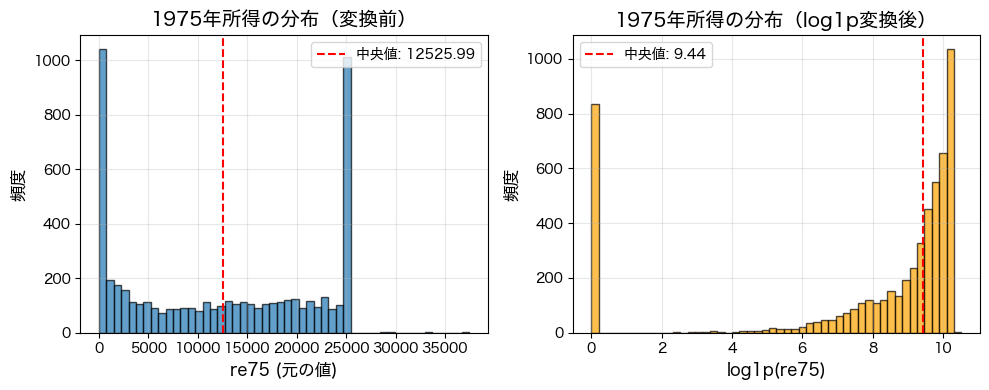

In [ ]:
# 対数変換前後の分布を比較
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 変換前の分布
axes[0].hist(df_train['re75'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('re75 (元の値)', fontsize=12)
axes[0].set_ylabel('頻度', fontsize=12)
axes[0].set_title('1975年所得の分布（変換前）', fontsize=14)
axes[0].axvline(df_train['re75'].median(), color='red', linestyle='--', 
                label=f'中央値: {df_train["re75"].median():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 対数変換後の分布
axes[1].hist(df_train['re75_log1p'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('log1p(re75)', fontsize=12)
axes[1].set_ylabel('頻度', fontsize=12)
axes[1].set_title('1975年所得の分布（log1p変換後）', fontsize=14)
axes[1].axvline(df_train['re75_log1p'].median(), color='red', linestyle='--',
                label=f'中央値: {df_train["re75_log1p"].median():.2f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 介入有無による特徴量の分布に違いの確認

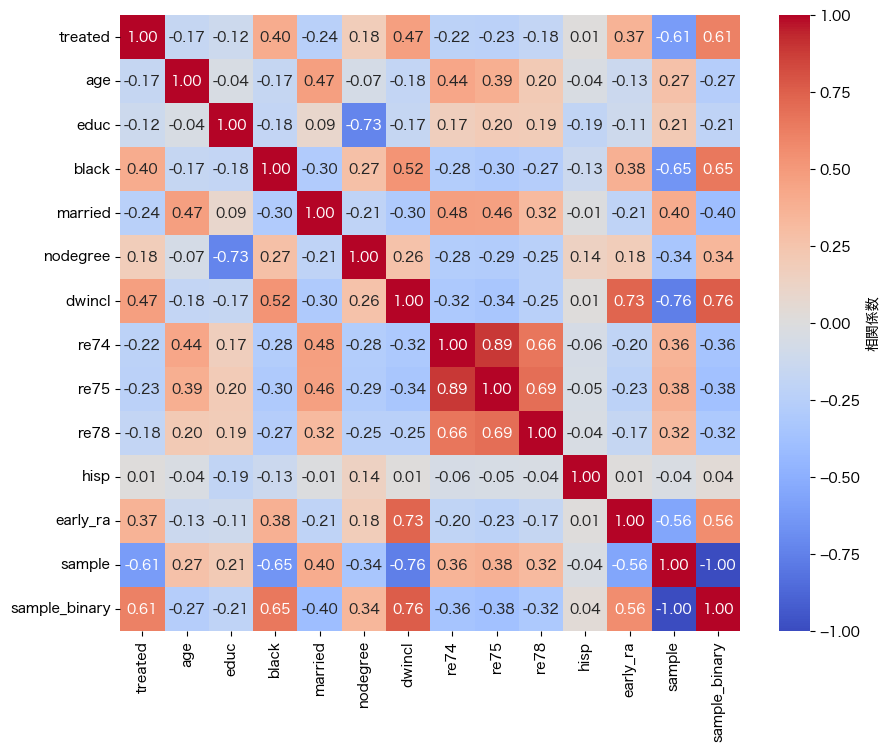

In [118]:
df_corr = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, cbar_kws={'label': '相関係数'})
plt.show()

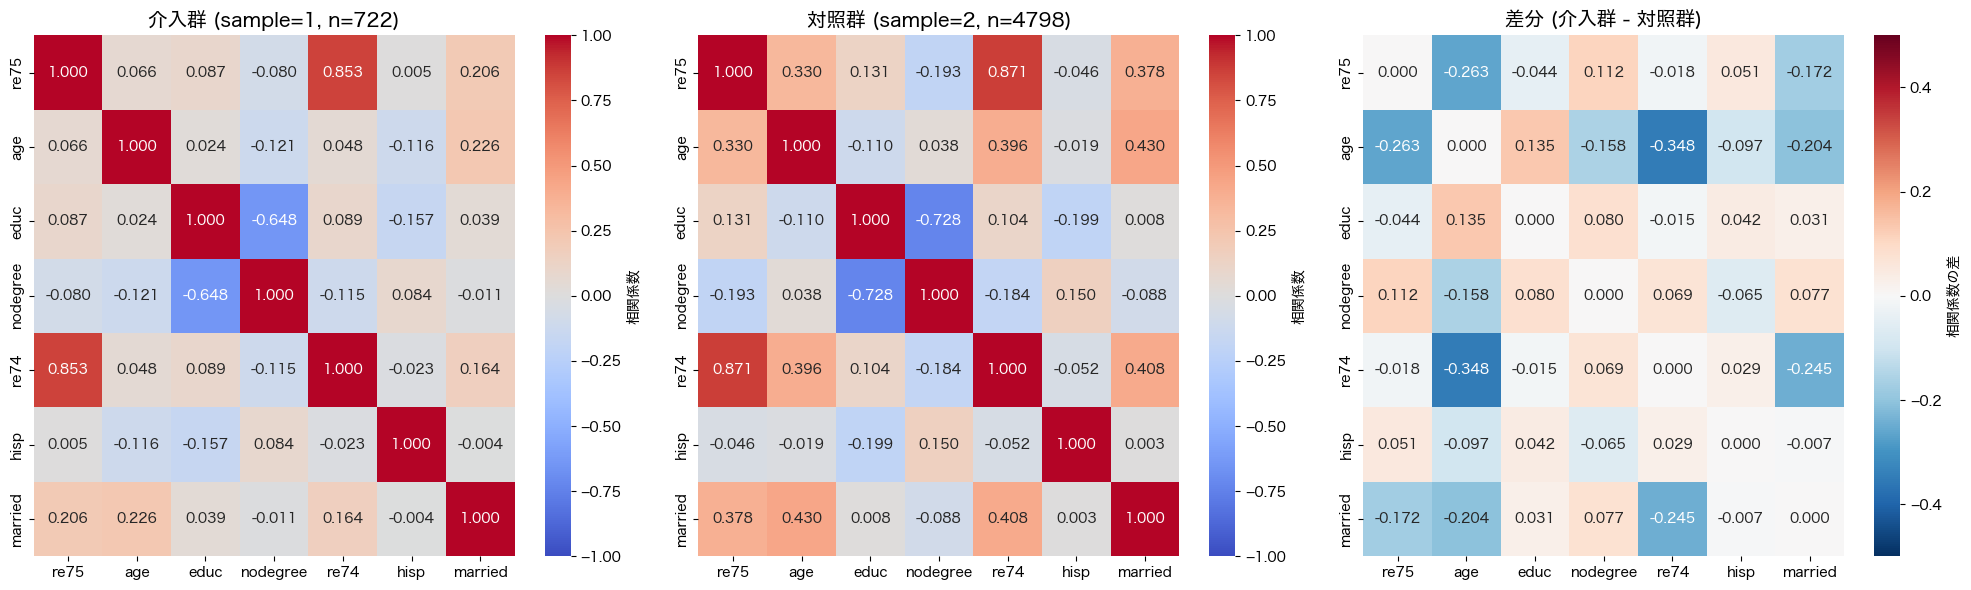


=== 相関係数の差が大きい組み合わせ（上位5つ）===
re74 vs age:
  介入群: 0.048, 対照群: 0.396, 差: -0.348
age vs re74:
  介入群: 0.048, 対照群: 0.396, 差: -0.348
age vs re75:
  介入群: 0.066, 対照群: 0.330, 差: -0.263
re75 vs age:
  介入群: 0.066, 対照群: 0.330, 差: -0.263
married vs re74:
  介入群: 0.164, 対照群: 0.408, 差: -0.245


In [119]:
# Xで条件づけたとしても、特徴量の分布が異なることを示したい
# treatment_colごとに、y_colとX_colsの相関係数行列をプロットする

# 介入群と対照群に分割
df_treated_group = df_train[df_train[treatment_col] == 1]
df_control_group = df_train[df_train[treatment_col] == 0]

# 相関係数を計算する列を選択
corr_cols = [y_col] + X_cols_for_y

# それぞれの群で相関係数行列を計算
corr_treated = df_treated_group[corr_cols].corr()
corr_control = df_control_group[corr_cols].corr()

# 相関係数行列の差分を計算
corr_diff = corr_treated - corr_control

# 3つのヒートマップを並べて可視化
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# 介入群の相関係数行列
sns.heatmap(corr_treated, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': '相関係数'})
axes[0].set_title(f'介入群 (sample=1, n={len(df_treated_group)})', fontsize=14)
# 対照群の相関係数行列
sns.heatmap(corr_control, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': '相関係数'})
axes[1].set_title(f'対照群 (sample=2, n={len(df_control_group)})', fontsize=14)
# 差分（介入群 - 対照群）
sns.heatmap(corr_diff, annot=True, fmt='.3f', cmap='RdBu_r', 
            center=0, vmin=-0.5, vmax=0.5, ax=axes[2], cbar_kws={'label': '相関係数の差'})
axes[2].set_title('差分 (介入群 - 対照群)', fontsize=14)
plt.tight_layout()
plt.show()

# 相関係数の差が大きい組み合わせをピックアップ
print("\n=== 相関係数の差が大きい組み合わせ（上位5つ）===")
# 差分行列を1次元化して絶対値でソート
corr_diff_abs = corr_diff.abs().unstack()
corr_diff_abs = corr_diff_abs[corr_diff_abs.index.get_level_values(0) != corr_diff_abs.index.get_level_values(1)]  # 対角成分を除外
corr_diff_sorted = corr_diff_abs.sort_values(ascending=False).head(5)

for (var1, var2), abs_diff in corr_diff_sorted.items():
    actual_diff = corr_diff.loc[var1, var2]
    treated_corr = corr_treated.loc[var1, var2]
    control_corr = corr_control.loc[var1, var2]
    print(f"{var1} vs {var2}:")
    print(f"  介入群: {treated_corr:.3f}, 対照群: {control_corr:.3f}, 差: {actual_diff:.3f}")

# 4. 介入確率モデルの構築（Propensity Score推定）

=== 介入確率モデルの評価 ===
ROC-AUC Score: 0.8862

介入確率の統計量:
count    5520.000000
mean        0.130798
std         0.187194
min         0.002683
25%         0.009322
50%         0.037115
75%         0.167679
max         0.643171
dtype: float64


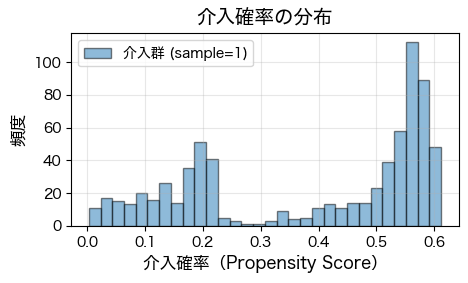

In [121]:
# 介入確率（propensity score）を推定するためのロジスティック回帰モデル
X_treatment = df_train[X_cols_for_treatment].values
y_treatment = df_train[treatment_col].values

# ロジスティック回帰モデルの構築と学習
propensity_model = LogisticRegression(max_iter=1000, random_state=42)
propensity_model.fit(X_treatment, y_treatment)

# 介入確率の予測
propensity_scores = propensity_model.predict_proba(X_treatment)[:, 1]

# 結果の確認
print("=== 介入確率モデルの評価 ===")
print(f"ROC-AUC Score: {roc_auc_score(y_treatment, propensity_scores):.4f}")
print(f"\n介入確率の統計量:")
print(pd.Series(propensity_scores).describe())

# 介入確率の分布を可視化
plt.figure(figsize=(5, 2.5))
plt.hist(propensity_scores[y_treatment == 1], bins=30, alpha=0.5, label='介入群 (sample=1)', edgecolor='black')
plt.xlabel('介入確率（Propensity Score）', fontsize=12)
plt.ylabel('頻度', fontsize=12)
plt.title('介入確率の分布', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. IW推定量の重み計算とクリッピング

=== 重みの統計量（クリッピング前）===
count    722.000000
mean       5.452691
std       20.958918
min        0.634825
25%        0.766558
50%        0.992456
75%        4.177355
max      371.781637
dtype: float64
最大値: 371.78
95パーセンタイル: 19.33

=== 重みの統計量（クリッピング後）===
count    722.000000
mean       3.462391
std        4.694377
min        0.634825
25%        0.766558
50%        0.992456
75%        4.177355
max       19.325598
dtype: float64
クリッピング閾値: 19.33


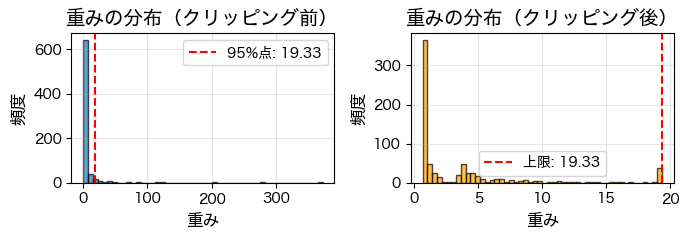

In [122]:
# IW推定量の重み計算: w = (1 - θ(X)) / θ(X)
# 介入群のデータに適用
df_treated = df_train[df_train[treatment_col] == 1].copy()
propensity_treated = propensity_model.predict_proba(df_treated[X_cols_for_treatment].values)[:, 1]

# 重みの計算
weights = (1 - propensity_treated) / propensity_treated

# 重みの統計量（クリッピング前）
print("=== 重みの統計量（クリッピング前）===")
print(pd.Series(weights).describe())
print(f"最大値: {weights.max():.2f}")
print(f"95パーセンタイル: {np.percentile(weights, 95):.2f}")

# 重みのクリッピング（95パーセンタイル）
weight_cap = np.percentile(weights, 95)
weights_clipped = np.clip(weights, 0, weight_cap)

print(f"\n=== 重みの統計量（クリッピング後）===")
print(pd.Series(weights_clipped).describe())
print(f"クリッピング閾値: {weight_cap:.2f}")

# 重みの分布を可視化
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5))

# クリッピング前
axes[0].hist(weights, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(weight_cap, color='red', linestyle='--', label=f'95%点: {weight_cap:.2f}')
axes[0].set_xlabel('重み', fontsize=12)
axes[0].set_ylabel('頻度', fontsize=12)
axes[0].set_title('重みの分布（クリッピング前）', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# クリッピング後
axes[1].hist(weights_clipped, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(weight_cap, color='red', linestyle='--', label=f'上限: {weight_cap:.2f}')
axes[1].set_xlabel('重み', fontsize=12)
axes[1].set_ylabel('頻度', fontsize=12)
axes[1].set_title('重みの分布（クリッピング後）', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# データフレームに重みを追加
df_treated['weights'] = weights_clipped

# 6. 重み付き線形回帰モデルの学習

In [123]:
# 介入群のデータで学習
X_train_treated = df_treated[X_cols_for_y].values
y_train_treated = df_treated[y_col].values

# 重み付きランダムフォレスト回帰モデル
model_weighted = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model_weighted.fit(X_train_treated, y_train_treated, sample_weight=df_treated['weights'])

# 重みなしランダムフォレスト回帰モデル（比較用）
model_unweighted = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model_unweighted.fit(X_train_treated, y_train_treated)

print("=== モデル学習完了 ===")
print(f"学習データ数: {len(X_train_treated)}")
print(f"特徴量数: {len(X_cols_for_y)}")
print(f"\n重み付きモデルの特徴量重要度:")
for i, col in enumerate(X_cols_for_y):
    print(f"  {col}: {model_weighted.feature_importances_[i]:.4f}")

print(f"\n重みなしモデルの特徴量重要度:")
for i, col in enumerate(X_cols_for_y):
    print(f"  {col}: {model_unweighted.feature_importances_[i]:.4f}")

=== モデル学習完了 ===
学習データ数: 722
特徴量数: 6

重み付きモデルの特徴量重要度:
  age: 0.0596
  educ: 0.0412
  nodegree: 0.0076
  re74: 0.8786
  hisp: 0.0022
  married: 0.0108

重みなしモデルの特徴量重要度:
  age: 0.0621
  educ: 0.0401
  nodegree: 0.0058
  re74: 0.8733
  hisp: 0.0057
  married: 0.0130


# 7. 未介入群（sample=2）での予測と評価

In [124]:
# 未介入群のデータを取得
df_control = df_train[df_train[treatment_col] == 0].copy()
X_control = df_control[X_cols_for_y].values
y_control_true = df_control[y_col].values

# 重み付きモデルで予測
y_pred_weighted = model_weighted.predict(X_control)

# 重みなしモデルで予測
y_pred_unweighted = model_unweighted.predict(X_control)

# 評価指標の計算
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n=== {model_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

# 各モデルの評価
metrics_weighted = evaluate_model(y_control_true, y_pred_weighted, "重み付きモデル")
metrics_unweighted = evaluate_model(y_control_true, y_pred_unweighted, "重みなしモデル")

# 評価指標の比較
print("\n=== 評価指標の比較 ===")
comparison_df = pd.DataFrame({
    '重み付きモデル': [metrics_weighted['rmse'], metrics_weighted['mae'], metrics_weighted['r2']],
    '重みなしモデル': [metrics_unweighted['rmse'], metrics_unweighted['mae'], metrics_unweighted['r2']],
    '差分': [
        metrics_weighted['rmse'] - metrics_unweighted['rmse'],
        metrics_weighted['mae'] - metrics_unweighted['mae'],
        metrics_weighted['r2'] - metrics_unweighted['r2']
    ]
}, index=['RMSE', 'MAE', 'R²'])
print(comparison_df)


=== 重み付きモデル ===
RMSE: 6380.9004
MAE: 5083.5175
R² Score: 0.5343

=== 重みなしモデル ===
RMSE: 6572.7774
MAE: 5267.1734
R² Score: 0.5059

=== 評価指標の比較 ===
          重み付きモデル      重みなしモデル          差分
RMSE  6380.900388  6572.777410 -191.877022
MAE   5083.517511  5267.173438 -183.655927
R²       0.534345     0.505919    0.028426


# 8. 結果の可視化

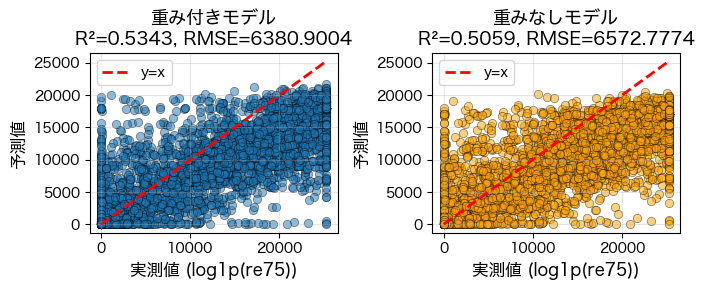

In [125]:
# 予測値 vs 実測値のプロット
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# 重み付きモデル
axes[0].scatter(y_control_true, y_pred_weighted, alpha=0.5, edgecolors='k', linewidths=0.5)
axes[0].plot([y_control_true.min(), y_control_true.max()], 
             [y_control_true.min(), y_control_true.max()], 
             'r--', lw=2, label='y=x')
axes[0].set_xlabel('実測値 (log1p(re75))', fontsize=12)
axes[0].set_ylabel('予測値', fontsize=12)
axes[0].set_title(f'重み付きモデル\nR²={metrics_weighted["r2"]:.4f}, RMSE={metrics_weighted["rmse"]:.4f}', 
                  fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 重みなしモデル
axes[1].scatter(y_control_true, y_pred_unweighted, alpha=0.5, edgecolors='k', linewidths=0.5, color='orange')
axes[1].plot([y_control_true.min(), y_control_true.max()], 
             [y_control_true.min(), y_control_true.max()], 
             'r--', lw=2, label='y=x')
axes[1].set_xlabel('実測値 (log1p(re75))', fontsize=12)
axes[1].set_ylabel('予測値', fontsize=12)
axes[1].set_title(f'重みなしモデル\nR²={metrics_unweighted["r2"]:.4f}, RMSE={metrics_unweighted["rmse"]:.4f}', 
                  fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

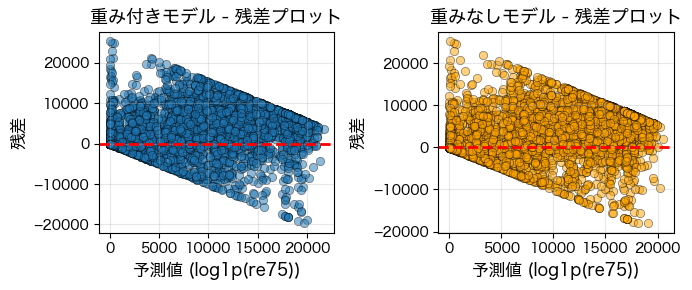

In [126]:
# 残差プロット
residuals_weighted = y_control_true - y_pred_weighted
residuals_unweighted = y_control_true - y_pred_unweighted

fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# 重み付きモデルの残差
axes[0].scatter(y_pred_weighted, residuals_weighted, alpha=0.5, edgecolors='k', linewidths=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('予測値 (log1p(re75))', fontsize=12)
axes[0].set_ylabel('残差', fontsize=12)
axes[0].set_title('重み付きモデル - 残差プロット', fontsize=13)
axes[0].grid(True, alpha=0.3)

# 重みなしモデルの残差
axes[1].scatter(y_pred_unweighted, residuals_unweighted, alpha=0.5, edgecolors='k', linewidths=0.5, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('予測値 (log1p(re75))', fontsize=12)
axes[1].set_ylabel('残差', fontsize=12)
axes[1].set_title('重みなしモデル - 残差プロット', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

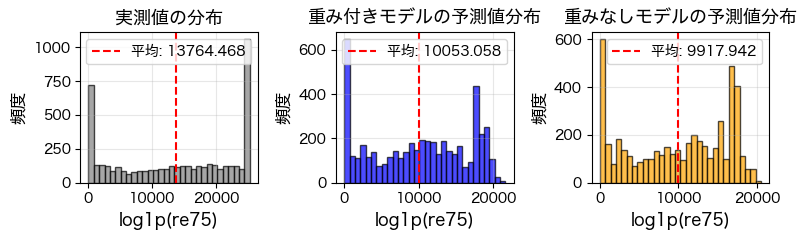

In [127]:
# 予測値の分布比較
fig, axes = plt.subplots(1, 3, figsize=(8, 2.5))

# 実測値の分布
axes[0].hist(y_control_true, bins=30, edgecolor='black', alpha=0.7, color='gray')
axes[0].set_xlabel('log1p(re75)', fontsize=12)
axes[0].set_ylabel('頻度', fontsize=12)
axes[0].set_title('実測値の分布', fontsize=13)
axes[0].axvline(y_control_true.mean(), color='red', linestyle='--', 
                label=f'平均: {y_control_true.mean():.3f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 重み付きモデルの予測値分布
axes[1].hist(y_pred_weighted, bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[1].set_xlabel('log1p(re75)', fontsize=12)
axes[1].set_ylabel('頻度', fontsize=12)
axes[1].set_title('重み付きモデルの予測値分布', fontsize=13)
axes[1].axvline(y_pred_weighted.mean(), color='red', linestyle='--',
                label=f'平均: {y_pred_weighted.mean():.3f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 重みなしモデルの予測値分布
axes[2].hist(y_pred_unweighted, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[2].set_xlabel('log1p(re75)', fontsize=12)
axes[2].set_ylabel('頻度', fontsize=12)
axes[2].set_title('重みなしモデルの予測値分布', fontsize=13)
axes[2].axvline(y_pred_unweighted.mean(), color='red', linestyle='--',
                label=f'平均: {y_pred_unweighted.mean():.3f}')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# まとめ

本ノートブックでは、IW推定量を用いて未介入群の1975年所得（re75）を予測しました。

## 手法のポイント
1. **目的変数の対数変換**: `log1p(re75)`により正規分布に近づけ、線形回帰の前提を満たしやすくしました
2. **介入確率モデル**: ロジスティック回帰で介入確率（propensity score）を推定
3. **重み計算**: IW推定量 `w = (1-θ)/θ` により選択バイアスを補正
4. **重みのクリッピング**: 95パーセンタイルで上限を設定し、極端な重みの影響を抑制
5. **重み付き線形回帰**: 介入群データに重みを適用して学習し、未介入群の所得を予測

## 結果の解釈
- 重み付きモデルと重みなしモデルの性能を比較することで、選択バイアス補正の効果を確認できます
- 予測値vs実測値のプロットで、モデルの予測精度を視覚的に評価できます
- 残差プロットで、モデルの偏りやパターンを確認できます